# Обучение с учителем: качество модели


In [31]:
# Необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Загрузка данных

In [ ]:
market_file = pd.read_csv("datasets/market_file.csv")  # Коммуникация с клиентом.
market_money = pd.read_csv("datasets/market_money.csv")  # Продуктовое поведение.
market_time = pd.read_csv("datasets/market_time.csv")  # Поведение на сайте.
money = pd.read_csv("datasets/money.csv", sep=";")  # Финансовое поведение.

### 2. Предобработка данных


In [ ]:
# Обзор данных - 1
data_list = [market_file, market_money, market_time, money]
for data in data_list:
    print(data[:3])
    print("==============")

In [ ]:
# Обзор данных - 2

for data in data_list:
    print(data.info())

In [ ]:
# Обзор данных - 3

for data in data_list:
    print(data.describe())

In [ ]:
# Поиск дубликатов
for data in data_list:
    print(data.duplicated().sum())

In [ ]:
# Поиск пропусков
for data in data_list:
    print(data.isna().sum())

Пропуски и дубликаты не обнаружены. Типы данных - количественные (int64, float64) и категориальные (object)

### 3. Исследовательский анализ данных

Шаг 1: Определение активных клиентов (≥3 периода с покупками)
Используем market_money.csv, где есть данные о выручке по периодам.

In [ ]:
# Фильтруем записи с ненулевой выручкой и считаем число уникальных периодов на клиента
active_clients = (
    market_money[market_money["Выручка"] > 0]
    .groupby("id")["Период"]
    .nunique()
    .loc[lambda x: x >= 3]
    .index
)

print(f"Клиентов с активностью ≥3 месяцев: {len(active_clients)}")

Шаг 2: Фильтрация всех таблиц по активным клиентам

In [ ]:

# Фильтрация
market_file_active = market_file[market_file["id"].isin(active_clients)]
market_money_active = market_money[market_money["id"].isin(active_clients)]
market_time_active = market_time[market_time["id"].isin(active_clients)]
money_active = money[money["id"].isin(active_clients)]
# Список фильтрованных датасетов
filtered_data_list = [market_file_active, market_money_active, market_time_active, money_active]

### 4. Объединение таблиц

In [ ]:
# Объединяем первую и вторую таблицы (merge, inner)
df = pd.merge(filtered_data_list[0], filtered_data_list[1], on='id', how='inner')

# Добавляем третью.
df = pd.merge(df, filtered_data_list[2], on='id', how='inner')
# Выводим результат
print(df.head())
display(df.info())

### 5. Корреляционный анализ

In [33]:
# Сначала отфильтруем столбцы, имеющие числовой тип (int64, float64), исключив ID и периоды:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['id', 'Период_x', 'Период_y']]
numerical_data = df[numerical_cols]
display(numerical_data.head())

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка,минут
0,4.4,4,819,0.75,4,4,2,5,4472.0,10
1,4.4,4,819,0.75,4,4,2,5,4472.0,12
2,4.4,4,819,0.75,4,4,2,5,4971.6,10
3,4.4,4,819,0.75,4,4,2,5,4971.6,12
4,4.4,4,819,0.75,4,4,2,5,5216.0,10


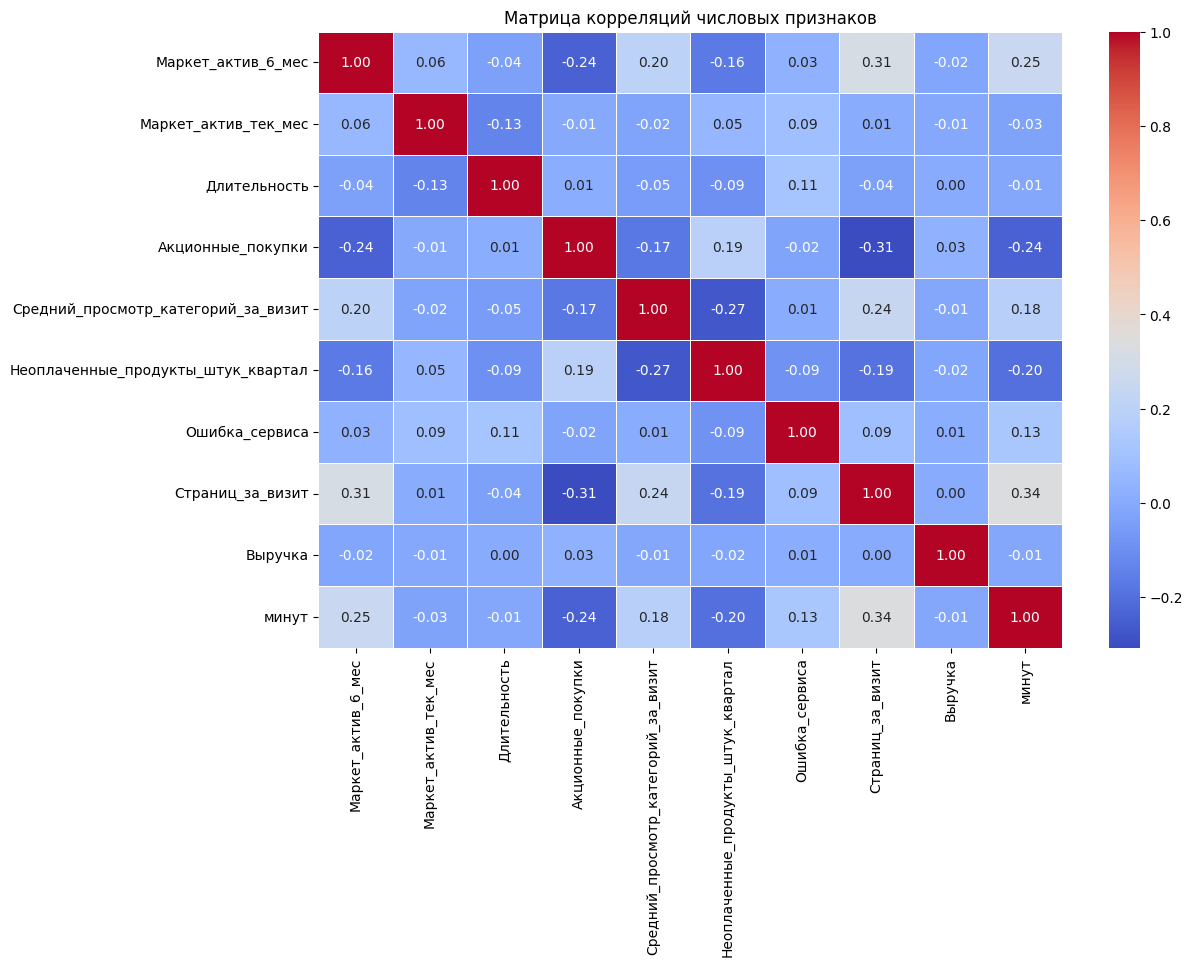

In [36]:

# Построение матрицы корреляций
plt.figure(figsize=(12, 8))
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляций числовых признаков")
plt.show()

Выводы: сильных корреляций нет, но есть слабые корреляции между признаками.
В случае необходимости можно удалить слабые корреляции: 
Страниц_за_визит коррелирует с:

Маркет_актив_6_мес (r=0.31)

Средний_просмотр_категорий_за_визит (r=0.24)

минут (r=0.34)